<a href="https://colab.research.google.com/github/SridharSurapaneni07/AAI520-team10-finalproject/blob/main/AAI520_Final_Project_Team10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team Details: Team 10 | Contributors: Sridhar Surapaneni, Narendra Iyer, Balaji Rao
Project Repository: https://github.com/SridharSurapaneni07/AAI520-team10-finalproject

Overview of the Project:

Our goal is to develop an intelligent agent for stock research that can:

Develop analysis plans for given stock symbols.
Use multiple data sources like financial APIs, news streams, and economic indicators.
Self-assess and improve its outputs via a feedback mechanism.
Retain simple session history for better ongoing evaluations.

Key Processes Demonstrated

Step-by-Step Handling: Gather news → Clean data → Sort categories → Pull insights → Generate overviews.
Data Allocation: Route information to focused modules (e.g., for news, earnings, or economy).
Enhancement Loop: Produce results → Review quality → Adjust using insights.

In [1]:
# Install dependencies quietly
!pip install -q yfinance pandas numpy scikit-learn matplotlib textblob nltk newsapi-python fredapi sec-edgar-downloader

In [2]:
import os
import json
import time
import math
import uuid
import string
import random
import pandas as pd
import numpy as np
import yfinance as yf
# Conditional imports for robustness
try:
    from newsapi import NewsApiClient
except ImportError:
    NewsApiClient = None
try:
    from fredapi import Fred
except ImportError:
    Fred = None
# Charting configurations
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 120)

In [3]:
# --- Settings & Basic Memory Storage ---
STOCK_SYMBOL = os.getenv("PROJECT_TICKER", "AAPL")
HISTORY_DAYS = int(os.getenv("LOOKBACK_DAYS", "365"))
NEWS_PERIOD_DAYS = int(os.getenv("NEWS_WINDOW_DAYS", "14"))
RISK_FREE_YIELD = float(os.getenv("RISK_FREE_RATE", "0.045"))  # yearly

MEMORY_FILE = os.getenv("AGENT_MEMO_PATH", "agent_memo.json")

def retrieve_memory(file=MEMORY_FILE):
    if os.path.exists(file):
        try:
            with open(file, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception:
            return {}
    return {}

def store_memory(memory_data, file=MEMORY_FILE):
    try:
        with open(file, "w", encoding="utf-8") as f:
            json.dump(memory_data, f, indent=2)
    except Exception as err:
        print("Failed to save memory:", err)

MEMORY = retrieve_memory()
MEMORY.setdefault("session_logs", [])
MEMORY.setdefault("symbols_tracked", {})

{}

In [4]:
# --- Function: Retrieve Stock Prices & Basics from Yahoo ---
from datetime import datetime, timedelta

def get_stock_history(symbol=STOCK_SYMBOL, period_days=HISTORY_DAYS):
    end_date = datetime.utcnow().date()
    start_date = end_date - timedelta(days=period_days)
    data_frame = yf.download(symbol, start=start_date.isoformat(), end=end_date.isoformat(), progress=False)
    data_frame = data_frame.rename(columns={"Adj Close": "AdjClose"})
    return data_frame

def compute_simple_metrics(price_data: pd.DataFrame) -> pd.DataFrame:
    df_copy = price_data.copy()
    df_copy["DailyReturn"] = df_copy["AdjClose"].pct_change()
    df_copy["Vol20Days"] = df_copy["DailyReturn"].rolling(window=20).std() * np.sqrt(252)
    df_copy["Avg20Days"] = df_copy["AdjClose"].rolling(window=20).mean()
    df_copy["Avg50Days"] = df_copy["AdjClose"].rolling(window=50).mean()
    df_copy["Mom20Days"] = df_copy["AdjClose"].pct_change(periods=20)
    return df_copy

In [5]:
# --- Function: News Intake (Stub for NewsAPI or Dataset) ---
from datetime import datetime, timedelta

def gather_news(symbol=STOCK_SYMBOL, period_days=NEWS_PERIOD_DAYS):
    """Produces a sample news DataFrame with basic structure.
    Swap with real NewsAPI or dataset loading in full setup.
    """
    end_date = datetime.utcnow().date()
    start_date = end_date - timedelta(days=period_days)
    entries = [
        {
            "date": str(start_date + timedelta(days=i)),
            "title": f"{symbol} example title {i}",
            "content": f"Sample text on {symbol} update {i}. Includes earnings or launches.",
            "source": "SampleSource"
        }
        for i in range(period_days)
    ]
    return pd.DataFrame(entries)

def prepare_news(data_frame: pd.DataFrame) -> pd.DataFrame:
    # Simple text cleanup and length check
    df_copy = data_frame.copy()
    df_copy["length"] = df_copy["content"].fillna("").str.len()
    df_copy["lowercase"] = df_copy["content"].fillna("").str.lower()
    return df_copy

def group_news(data_frame: pd.DataFrame) -> pd.DataFrame:
    # Basic rule for grouping (update with AI model later)
    df_copy = data_frame.copy()
    df_copy["group"] = np.where(df_copy["lowercase"].str.contains("earnings|outlook|high|surpass"), "core",
                   np.where(df_copy["lowercase"].str.contains("release|new|version"), "innovation",
                   "standard"))
    return df_copy

def detect_indicators(data_frame: pd.DataFrame) -> pd.DataFrame:
    # Simple indicator: +1 if positive terms appear
    df_copy = data_frame.copy()
    positive = df_copy["lowercase"].str.contains("high|surpass|increase|positive")
    negative = df_copy["lowercase"].str.contains("reduce|fall|below|delay")
    df_copy["indicator"] = np.select([positive, negative], [1, -1], default=0)
    return df_copy

def create_overview(data_frame: pd.DataFrame) -> str:
    group_counts = data_frame["group"].value_counts(dropna=False).to_dict()
    total_indicator = int(data_frame["indicator"].sum())
    overview_lines = [
        f"News groups: {group_counts}",
        f"Overall indicator score (simple): {total_indicator:+d}",
        "Main insights:",
        "- Core topics suggest sensitivity to earnings/outlook.",
        "- Innovation topics could affect future trends.",
        "- Standard topics offer general background."
    ]
    return "\n".join(overview_lines)

In [6]:
# --- Direction: Assign to specific processor ---
def assign_path(entry: dict) -> str:
    combined_text = (entry.get("title","") + " " + entry.get("content","")).lower()
    if any(term in combined_text for term in ["earnings","outlook","sales","gain","edge"]):
        return "financial_processor"
    if any(term in combined_text for term in ["inflation","jobs","fed","growth","cpi"]):
        return "economic_processor"
    return "general_processor"

def implement_direction(data_frame: pd.DataFrame) -> pd.DataFrame:
    df_copy = data_frame.copy()
    df_copy["path"] = df_copy.apply(assign_path, axis=1)
    return df_copy

In [7]:
# --- Reviewer-Enhancer: Self-review and adjustment cycle ---
def produce_evaluation(symbol, price_data, news_data) -> str:
    recent_close = float(price_data["AdjClose"].iloc[-1])
    volatility = float(price_data["Vol20Days"].iloc[-1])
    news_overview = create_overview(news_data)
    initial_draft = f"""Evaluation v1 for {symbol}:
- Recent close: {recent_close:.2f}
- 20-day yearly volatility: {volatility:.2%}
- News overview:
{news_overview}

Preliminary assessment: Mix of core and innovation factors in latest period.
"""
    return initial_draft

def assess_standard(text: str) -> dict:
    # Simple reviewer: check length and sections
    rating = 0
    validations = {}
    validations["includes_close"] = "Recent close" in text
    validations["includes_vol"] = "volatility" in text.lower()
    validations["includes_overview"] = "News overview" in text
    rating = sum(int(v) for v in validations.values())
    return {"rating": rating, "validations": validations}

def adjust_with_review(text: str, review_summary: dict) -> str:
    updated = text
    if not review_summary["validations"].get("includes_close", False):
        updated += "\nAdded: Recent close value."
    if not review_summary["validations"].get("includes_vol", False):
        updated += "\nAdded: 20-day yearly volatility."
    if not review_summary["validations"].get("includes_overview", False):
        updated += "\nAdded: News overview section."
    updated += "\nAdjustment note: Add risk view relative to risk-free yield."
    return updated

In [8]:
# --- Coordinator: Analysis Phases ---
PHASES = [
    "Retrieve price history",
    "Calculate simple metrics (returns, vol, averages)",
    "Gather & prepare recent news",
    "Group and detect indicators",
    "Assign to processor paths",
    "Create initial evaluation",
    "Review and adjust evaluation (Reviewer-Enhancer)",
    "Save short memory and outcomes"
]

def execute_agent(symbol=STOCK_SYMBOL):
    print("Phases:", *[f"{idx+1}. {phase}" for idx,phase in enumerate(PHASES)], sep="\n")
    historical_prices = get_stock_history(symbol)
    calculated_metrics = compute_simple_metrics(historical_prices)
    recent_news = gather_news(symbol)
    prepared_news = prepare_news(recent_news)
    grouped_news = group_news(prepared_news)
    indicated_news = detect_indicators(grouped_news)
    directed_news = implement_direction(indicated_news)

    initial = produce_evaluation(symbol, calculated_metrics.dropna(), directed_news)
    review_summary = assess_standard(initial)
    enhanced = adjust_with_review(initial, review_summary)

    # Save basic memory
    MEMORY["symbols_tracked"].setdefault(symbol, 0)
    MEMORY["symbols_tracked"][symbol] += 1
    MEMORY["session_logs"].append({
        "symbol": symbol,
        "timestamp": time.time(),
        "review_rating": review_summary["rating"]
    })
    store_memory(MEMORY)

    return {
        "historical_prices": historical_prices,
        "calculated_metrics": calculated_metrics,
        "recent_news": directed_news,
        "initial": initial,
        "review": review_summary,
        "enhanced": enhanced
    }

# Sample run (offline-safe with sample news)
# outcomes = execute_agent(STOCK_SYMBOL)
# print(outcomes["enhanced"][:800])

In [10]:
# --- Visualization Aids ---
def chart_prices_with_averages(data_frame: pd.DataFrame, symbol=STOCK_SYMBOL):
    data_frame = data_frame.dropna(subset=["AdjClose"])
    plt.figure(figsize=(10,4))
    data_frame["AdjClose"].plot(label=f"{symbol} AdjClose")
    if "Avg20Days" in data_frame: data_frame["Avg20Days"].plot(label="Avg20Days")
    if "Avg50Days" in data_frame: data_frame["Avg50Days"].plot(label="Avg50Days")
    plt.title(f"{symbol} Prices with Averages")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage after agent run:
# chart_prices_with_averages(outcomes["calculated_metrics"])

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

In [12]:
!pip install fredapi

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from fredapi import Fred

# --- Standard Configurations ---
STANDARD_SYMBOL = "RELIANCE.NS"
STANDARD_DURATION = "5y"
RECOMMENDED_SYMBOLS = [
    "RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", "TCS.NS",
    "SBIN.NS", "LT.NS", "BHARTIARTL.NS", "ITC.NS", "ASIANPAINT.NS"
]
FRED_KEY = '5f43b12d79e8665de611dd3d44b0e714'  # Update with your API key

# --- Information Retrieval Functions ---

# Yahoo Finance Prices
def create_sample_prices(symbol=STANDARD_SYMBOL, duration=1260):
    time_points = pd.date_range(end=datetime.today(), periods=duration, freq='B')
    data_frame = pd.DataFrame({
        'Date': time_points,
        'Open': np.random.uniform(100, 200, size=duration),
        'High': np.random.uniform(200, 300, size=duration),
        'Low': np.random.uniform(50, 100, size=duration),
        'Close': np.random.uniform(100, 200, size=duration),
        'Adj Close': np.random.uniform(100, 200, size=duration),
        'Volume': np.random.randint(1000000, 5000000, size=duration),
        'Ticker': symbol
    })
    return data_frame

def retrieve_yfinance_info(symbol=STANDARD_SYMBOL, duration=STANDARD_DURATION, sample_duration=1260):
    """Get price info for one symbol"""
    try:
        data_frame = yf.download(symbol, period=duration, progress=False, auto_adjust=False)
        if data_frame.empty:
            raise ValueError("Empty response")
        if isinstance(data_frame.columns, pd.MultiIndex):
            data_frame.columns = data_frame.columns.get_level_values(0)
        data_frame = data_frame.reset_index()
        essential_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        for col in essential_cols:
            if col not in data_frame.columns:
                data_frame[col] = np.nan
        data_frame = data_frame[essential_cols]
        data_frame['Ticker'] = symbol
        print(f"Yahoo data retrieved for {symbol}")
    except Exception as err:
        print(f"Yahoo error for {symbol}: {err}. Creating sample data.")
        data_frame = create_sample_prices(symbol=symbol, duration=sample_duration)
    return data_frame

# SEC Filing Samples
def retrieve_sec_info(symbol=STANDARD_SYMBOL, entries_per_symbol=5):
    types = ['10-K', '10-Q', '8-K', 'S-1', 'DEF 14A']
    sample_entries = []
    for i in range(entries_per_symbol):
        entry_date = datetime.today() - timedelta(days=np.random.randint(1, 365))
        entry_type = np.random.choice(types)
        sample_entries.append({
            'Ticker': symbol,
            'FilingDate': entry_date,
            'FormType': entry_type,
            'Title': f"{symbol} {entry_type} Entry",
            'Summary': f"Overview of {entry_type} entry for {symbol}.",
            'FilingLink': f"https://www.sec.gov/Archives/edgar/data/{symbol}/{i}",
            'Source': 'SEC EDGAR'
        })
    return pd.DataFrame(sample_entries)

# Sample Financial Updates
def create_sample_updates(symbol=STANDARD_SYMBOL, duration=1825):
    update_data = []
    for i in range(duration):
        update_data.append({
            'Ticker': symbol,
            'Date': datetime.today() - timedelta(days=i),
            'Headline': f"Sample update {i+1} for {symbol}",
            'Category': np.random.choice(['Economy', 'Company', 'Market']),
        })
    return pd.DataFrame(update_data)

# FRED Economy Info
def retrieve_fred_info(series_code, duration_years=5):
    """Get economy info for past years from FRED"""
    end = datetime.today().strftime('%Y-%m-%d')
    start = (datetime.today() - pd.DateOffset(years=duration_years)).strftime('%Y-%m-%d')

    try:
        fred_instance = Fred(api_key=FRED_KEY)
        info = fred_instance.get_series(series_code, start, end)
        data_frame = pd.DataFrame(info, columns=[series_code])
        data_frame['Date'] = data_frame.index
        data_frame.set_index('Date', inplace=True)
        print(f"FRED info retrieved for {series_code} ({start} to {end})")
        return data_frame
    except Exception as err:
        print(f"FRED error for {series_code}: {err}")
        return pd.DataFrame()

# --- Run Retrieval for RECOMMENDED_SYMBOLS ---

# Yahoo for recommended symbols
all_prices = [retrieve_yfinance_info(symbol=s) for s in RECOMMENDED_SYMBOLS]
merged_prices_df = pd.concat(all_prices, ignore_index=True)
print("=== Prices Data ===")
print(merged_prices_df.head())

# SEC for recommended symbols
all_sec = [retrieve_sec_info(symbol=s) for s in RECOMMENDED_SYMBOLS]
sec_df = pd.concat(all_sec, ignore_index=True)
print("=== SEC Entries ===")
print(sec_df.head())

# Sample Updates for recommended symbols
all_updates = [create_sample_updates(symbol=s) for s in RECOMMENDED_SYMBOLS]
sample_updates_df = pd.concat(all_updates, ignore_index=True)
print("=== Sample Updates ===")
print(sample_updates_df.head())

# FRED Economy
gdp_info = retrieve_fred_info('GDPC1')
unemp_info = retrieve_fred_info('UNRATE')
cpi_info = retrieve_fred_info('CPIAUCSL')

economy_df = gdp_info.join([unemp_info, cpi_info], how='outer')
economy_df = economy_df.sort_index().ffill().infer_objects(copy=False)
print("=== Economy Data ===")
print(economy_df.head())

Yahoo data retrieved for RELIANCE.NS
Yahoo data retrieved for HDFCBANK.NS
Yahoo data retrieved for ICICIBANK.NS
Yahoo data retrieved for INFY.NS
Yahoo data retrieved for TCS.NS
Yahoo data retrieved for SBIN.NS
Yahoo data retrieved for LT.NS
Yahoo data retrieved for BHARTIARTL.NS
Yahoo data retrieved for ITC.NS
Yahoo data retrieved for ASIANPAINT.NS
=== Prices Data ===
Price       Date         Open         High         Low        Close  \
0     2020-10-19  1010.707703  1028.544678  994.601379  1004.315918   
1     2020-10-20  1005.608154  1012.069153  993.263000   994.947510   
2     2020-10-21  1000.531677  1011.607666  968.111267   980.502563   
3     2020-10-22   981.794739   984.148376  964.996155   972.357056   
4     2020-10-23   971.918640   985.302124  967.488281   975.172241   

Price   Adj Close    Volume       Ticker  
0      986.757019  31200385  RELIANCE.NS  
1      977.552490  18482288  RELIANCE.NS  
2      963.359985  34082321  RELIANCE.NS  
3      955.356995  30802210  R

In [14]:
# Verify data types
merged_prices_df['Date'] = pd.to_datetime(merged_prices_df['Date'])
sample_updates_df['Date'] = pd.to_datetime(sample_updates_df['Date'])
merged_prices_df['Ticker'] = merged_prices_df['Ticker'].astype(str)
sample_updates_df['Ticker'] = sample_updates_df['Ticker'].astype(str)

# Summarize updates by symbol and date
daily_update_tally = (
    sample_updates_df.groupby(['Ticker', 'Date'])
    .size()
    .reset_index(name='UpdateTally')
)

# Combine prices with updates
prices_updates_df = pd.merge(
    merged_prices_df,
    daily_update_tally,
    on=['Ticker', 'Date'],
    how='left'
)

# Handle missing updates
prices_updates_df['UpdateTally'] = prices_updates_df['UpdateTally'].fillna(0).astype(int)

print("✅ Phase 1 complete: Prices + Updates combined")
print(prices_updates_df.head())

✅ Phase 1 complete: Prices + Updates combined
        Date         Open         High         Low        Close   Adj Close  \
0 2020-10-19  1010.707703  1028.544678  994.601379  1004.315918  986.757019   
1 2020-10-20  1005.608154  1012.069153  993.263000   994.947510  977.552490   
2 2020-10-21  1000.531677  1011.607666  968.111267   980.502563  963.359985   
3 2020-10-22   981.794739   984.148376  964.996155   972.357056  955.356995   
4 2020-10-23   971.918640   985.302124  967.488281   975.172241  958.122925   

     Volume       Ticker  UpdateTally  
0  31200385  RELIANCE.NS            0  
1  18482288  RELIANCE.NS            0  
2  34082321  RELIANCE.NS            0  
3  30802210  RELIANCE.NS            0  
4  23422125  RELIANCE.NS            0  


In [15]:
# Adjust filing dates
sec_df['FilingDate'] = pd.to_datetime(sec_df['FilingDate'])
sec_df['Ticker'] = sec_df['Ticker'].astype(str)

# Order for merging
prices_updates_ordered = prices_updates_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
sec_ordered = sec_df.sort_values(['Ticker', 'FilingDate']).reset_index(drop=True)

combined_parts = []
for symbol in prices_updates_ordered['Ticker'].unique():
    prices_sym = prices_updates_ordered[prices_updates_ordered['Ticker'] == symbol]
    sec_sym = sec_ordered[sec_ordered['Ticker'] == symbol]

    if not sec_sym.empty:
        combined = pd.merge_asof(
            prices_sym.sort_values('Date'),
            sec_sym.drop(columns=['Ticker'], errors='ignore').sort_values('FilingDate'),
            left_on='Date',
            right_on='FilingDate',
            direction='backward'
        )
    else:
        combined = prices_sym.copy()
        combined['FilingDate'] = pd.NaT
        combined['FormType'] = np.nan
        combined['Title'] = np.nan
        combined['Summary'] = np.nan
        combined['FilingLink'] = np.nan
        combined['Source'] = np.nan

    combined['Ticker'] = symbol
    combined_parts.append(combined)

prices_updates_sec_df = pd.concat(combined_parts, ignore_index=True)

print("✅ Phase 2 complete: Prices + Updates + SEC combined")
print(prices_updates_sec_df.head())

✅ Phase 2 complete: Prices + Updates + SEC combined
        Date         Open         High          Low        Close    Adj Close  \
0 2020-10-19  2079.949951  2079.949951  2056.500000  2070.100098  1981.507568   
1 2020-10-20  2077.899902  2131.800049  2067.350098  2118.500000  2027.836426   
2 2020-10-21  2130.000000  2143.850098  2081.250000  2114.300049  2023.816162   
3 2020-10-22  2114.199951  2116.850098  2076.800049  2099.899902  2010.032227   
4 2020-10-23  2113.500000  2129.399902  2096.000000  2120.250000  2029.511475   

    Volume         Ticker  UpdateTally FilingDate FormType Title Summary  \
0  1338404  ASIANPAINT.NS            0        NaT      NaN   NaN     NaN   
1  2377713  ASIANPAINT.NS            0        NaT      NaN   NaN     NaN   
2  2895432  ASIANPAINT.NS            0        NaT      NaN   NaN     NaN   
3  2755686  ASIANPAINT.NS            0        NaT      NaN   NaN     NaN   
4  3070714  ASIANPAINT.NS            0        NaT      NaN   NaN     NaN   

  Fi

In [16]:
# Reset and prepare economy data
economy_ordered = economy_df.sort_index().ffill().reset_index().rename(columns={'index':'Date'})
economy_ordered['Date'] = pd.to_datetime(economy_ordered['Date'])

# Order main data
prices_updates_sec_ordered = prices_updates_sec_df.sort_values('Date').reset_index(drop=True)

# Combine with economy
full_df = pd.merge_asof(
    prices_updates_sec_ordered,
    economy_ordered,
    on='Date',
    direction='backward'
)

print("Phase 3 complete: Included economy metrics")
print(full_df.head())
print("Fields in full dataset:", full_df.columns.tolist())

Phase 3 complete: Included economy metrics
        Date         Open         High          Low        Close    Adj Close  \
0 2020-10-19  2079.949951  2079.949951  2056.500000  2070.100098  1981.507568   
1 2020-10-19   196.199997   204.600006   196.050003   204.000000   188.234177   
2 2020-10-19  1010.707703  1028.544678   994.601379  1004.315918   986.757019   
3 2020-10-19   899.000000   906.000000   884.000000   902.900024   840.527527   
4 2020-10-19  2774.000000  2774.000000  2706.600098  2711.550049  2422.384033   

     Volume         Ticker  UpdateTally FilingDate FormType Title Summary  \
0   1338404  ASIANPAINT.NS            0        NaT      NaN   NaN     NaN   
1  60220779        SBIN.NS            0        NaT      NaN   NaN     NaN   
2  31200385    RELIANCE.NS            0        NaT      NaN   NaN     NaN   
3   5800391          LT.NS            0        NaT      NaN   NaN     NaN   
4   3331194         TCS.NS            0        NaT      NaN   NaN     NaN   

  Filin

In [17]:
# Save path
output_file = "./full_investment_data.csv"

# Export DataFrame
full_df.to_csv(output_file, index=False)

print(f"full_df exported to '{output_file}'")

full_df exported to './full_investment_data.csv'


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Load data
data_set = pd.read_csv("./full_investment_data.csv")

In [20]:
# Display fields
data_set.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'UpdateTally', 'FilingDate', 'FormType', 'Title', 'Summary',
       'FilingLink', 'Source', 'GDPC1', 'UNRATE', 'CPIAUCSL'],
      dtype='object')

In [21]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12380 entries, 0 to 12379
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         12380 non-null  object 
 1   Open         12380 non-null  float64
 2   High         12380 non-null  float64
 3   Low          12380 non-null  float64
 4   Close        12380 non-null  float64
 5   Adj Close    12380 non-null  float64
 6   Volume       12380 non-null  int64  
 7   Ticker       12380 non-null  object 
 8   UpdateTally  12380 non-null  int64  
 9   FilingDate   1988 non-null   object 
 10  FormType     1988 non-null   object 
 11  Title        1988 non-null   object 
 12  Summary      1988 non-null   object 
 13  FilingLink   1988 non-null   object 
 14  Source       1988 non-null   object 
 15  GDPC1        12380 non-null  float64
 16  UNRATE       12380 non-null  float64
 17  CPIAUCSL     12380 non-null  float64
dtypes: float64(8), int64(2), object(8)
memory usag

In [22]:
data_set = data_set.rename(columns={
    "Source": "InfoOrigin",
    "GDPC1": "ActualGDP",
    "UNRATE": "JoblessRate",
    "CPIAUCSL": "PriceIndex"
})

In [23]:
# Check missing values
data_set.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Ticker,0
UpdateTally,0
FilingDate,10392


In [24]:
data_final = data_set.copy()

In [25]:
data_final.shape

(12380, 18)

In [26]:
# Convert FilingDate to datetime
data_final['FilingDate'] = pd.to_datetime(data_final['FilingDate'], errors='coerce')

# Order by symbol and date
data_final = data_final.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Fill FilingDate forward then backward
data_final['FilingDate'] = data_final.groupby('Ticker')['FilingDate'].transform(lambda x: x.ffill().bfill())

# Flag for original filings
data_final['FilingPresent'] = data_final['FilingDate'].notna().astype(int)

# Verify
print(data_final[['Ticker', 'Date', 'FilingDate', 'FilingPresent']].head(10))
print("Remaining missing after fill:", data_final['FilingDate'].isna().sum())

          Ticker        Date                 FilingDate  FilingPresent
0  ASIANPAINT.NS  2020-10-19 2025-02-20 15:00:50.425596              1
1  ASIANPAINT.NS  2020-10-20 2025-02-20 15:00:50.425596              1
2  ASIANPAINT.NS  2020-10-21 2025-02-20 15:00:50.425596              1
3  ASIANPAINT.NS  2020-10-22 2025-02-20 15:00:50.425596              1
4  ASIANPAINT.NS  2020-10-23 2025-02-20 15:00:50.425596              1
5  ASIANPAINT.NS  2020-10-26 2025-02-20 15:00:50.425596              1
6  ASIANPAINT.NS  2020-10-27 2025-02-20 15:00:50.425596              1
7  ASIANPAINT.NS  2020-10-28 2025-02-20 15:00:50.425596              1
8  ASIANPAINT.NS  2020-10-29 2025-02-20 15:00:50.425596              1
9  ASIANPAINT.NS  2020-10-30 2025-02-20 15:00:50.425596              1
Remaining missing after fill: 0


In [27]:
data_final['FormType'] = data_final['FormType'].fillna('Unspecified')
data_final['Title'] = data_final['Title'].fillna('Untitled')
data_final['Summary'] = data_final['Summary'].fillna('No Overview')
data_final['FilingLink'] = data_final['FilingLink'].fillna('No URL')
data_final['InfoOrigin'] = data_final['InfoOrigin'].fillna('Unspecified')

In [28]:
data_final.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Ticker,0
UpdateTally,0
FilingDate,0


In [29]:
# Adjust dates
data_final['FilingDate'] = pd.to_datetime(data_final['FilingDate'], errors='coerce')
data_final['Date'] = pd.to_datetime(data_final['Date'], errors='coerce')

In [30]:
# Identify duplicates
duplicates = data_final[data_final.duplicated()]
print(f"Duplicate count: {duplicates.shape[0]}")
print(duplicates)

Duplicate count: 0
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume, Ticker, UpdateTally, FilingDate, FormType, Title, Summary, FilingLink, InfoOrigin, ActualGDP, JoblessRate, PriceIndex, FilingPresent]
Index: []


In [31]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12380 entries, 0 to 12379
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           12380 non-null  datetime64[ns]
 1   Open           12380 non-null  float64       
 2   High           12380 non-null  float64       
 3   Low            12380 non-null  float64       
 4   Close          12380 non-null  float64       
 5   Adj Close      12380 non-null  float64       
 6   Volume         12380 non-null  int64         
 7   Ticker         12380 non-null  object        
 8   UpdateTally    12380 non-null  int64         
 9   FilingDate     12380 non-null  datetime64[ns]
 10  FormType       12380 non-null  object        
 11  Title          12380 non-null  object        
 12  Summary        12380 non-null  object        
 13  FilingLink     12380 non-null  object        
 14  InfoOrigin     12380 non-null  object        
 15  ActualGDP      1238

In [32]:
# Convert to numbers
data_final['Open'] = pd.to_numeric(data_final['Open'], errors='coerce')
data_final['High'] = pd.to_numeric(data_final['High'], errors='coerce')
data_final['Low'] = pd.to_numeric(data_final['Low'], errors='coerce')
data_final['Close'] = pd.to_numeric(data_final['Close'], errors='coerce')
data_final['Adj Close'] = pd.to_numeric(data_final['Adj Close'], errors='coerce')
data_final['ActualGDP'] = pd.to_numeric(data_final['ActualGDP'], errors='coerce')
data_final['JoblessRate'] = pd.to_numeric(data_final['JoblessRate'], errors='coerce')
data_final['PriceIndex'] = pd.to_numeric(data_final['PriceIndex'], errors='coerce')

# Format decimals
num_fields = ['Open', 'High', 'Low', 'Close', 'Adj Close',
              'ActualGDP', 'JoblessRate', 'PriceIndex']

for field in num_fields:
    data_final[field] = data_final[field].apply(lambda val: f"{val:.2f}" if pd.notnull(val) else "NaN")

In [33]:
data_final.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'UpdateTally', 'FilingDate', 'FormType', 'Title', 'Summary',
       'FilingLink', 'InfoOrigin', 'ActualGDP', 'JoblessRate', 'PriceIndex',
       'FilingPresent'],
      dtype='object')

In [34]:
# Duplicate original
data_copy = data_final.copy()

In [35]:
type(data_copy)
data_copy.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'UpdateTally', 'FilingDate', 'FormType', 'Title', 'Summary',
       'FilingLink', 'InfoOrigin', 'ActualGDP', 'JoblessRate', 'PriceIndex',
       'FilingPresent'],
      dtype='object')

In [36]:
!pip install textblob

In [37]:
from textblob import TextBlob
# Sequence: Intake data → Prepare → Analyze mood → Overview

In [38]:
# -----------------------------
# INTAKE: Form prompt from data_copy fields
# -----------------------------
def form_prompt(entry):
    """Generates text prompt from key fields."""
    return (
        f"On {entry['Date']}, symbol {entry['Ticker']} started at {entry['Open']}, "
        f"ended at {entry['Close']}. PriceIndex: {entry.get('PriceIndex', 'N/A')}, "
        f"JoblessRate: {entry.get('JoblessRate', 'N/A')}, GDP: {entry.get('ActualGDP', 'N/A')}."
    )

# -----------------------------
# PREPARATION
# -----------------------------
def clean_prompt(text_input):
    """Simple text normalization."""
    return str(text_input).strip().replace("  ", " ")

# -----------------------------
# MOOD ANALYSIS
# -----------------------------
POSITIVE_TERMS = {"surpass", "growth", "positive winds", "enhanced", "elevated", "peak", "increases", "expansion", "revenue up", "incentives"}
NEGATIVE_TERMS = {"fail", "soft market", "low", "penalty", "probe", "inquiry", "challenges", "drop", "price rise"}

def calc_econ_limits(data_frame):
    limits = {}
    for field in ['PriceIndex', 'JoblessRate', 'ActualGDP']:
        if field in data_frame.columns:
            avg, dev = data_frame[field].mean(), data_frame[field].std()
            limits[field] = {'bottom': avg - dev, 'top': avg + dev, 'avg': avg}
    return limits

def mixed_mood(entry, limits):
    """Determine mood from numbers and terms in text."""
    value = 0

    # Price mood
    if entry['Close'] > entry['Open']:
        value += 1
    elif entry['Close'] < entry['Open']:
        value -= 1

    # Econ factors
    for econ in ['PriceIndex', 'JoblessRate', 'ActualGDP']:
        if econ in entry and econ in limits:
            if econ == 'ActualGDP' and entry[econ] > limits[econ]['top']:
                value += 1
            elif econ == 'ActualGDP' and entry[econ] < limits[econ]['bottom']:
                value -= 1
            elif econ != 'ActualGDP' and entry[econ] < limits[econ]['bottom']:
                value += 1
            elif econ != 'ActualGDP' and entry[econ] > limits[econ]['top']:
                value -= 1

    # Text terms
    text_lower = str(entry['CleanedText']).lower()
    pos_count = sum(term in text_lower for term in POSITIVE_TERMS)
    neg_count = sum(term in text_lower for term in NEGATIVE_TERMS)
    value += pos_count - neg_count

    # Mood category
    if value > 0:
        return "optimistic"
    elif value < 0:
        return "pessimistic"
    else:
        return "balanced"

# -----------------------------
# OVERVIEW CREATION
# -----------------------------
def overview_prompt(entry):
    """Create formatted overview with mood and description."""
    description = {
        "optimistic": "Market displayed resilience with favorable signs.",
        "pessimistic": "Market mood was subdued with unfavorable cues.",
        "balanced": "Market stayed even without clear direction."
    }
    return f"Overview: {entry['CleanedText']} General Mood: {entry['Mood'].upper()}. {description[entry['Mood']]}"

# -----------------------------
# CORE SEQUENCE
# -----------------------------
def execute_sequence(data_copy):
    # Intake
    data_copy['PromptText'] = data_copy.apply(form_prompt, axis=1)

    # Preparation
    data_copy['CleanedText'] = data_copy['PromptText'].apply(clean_prompt)

    # Calc limits for numbers
    limits = calc_econ_limits(data_copy)

    # Mood grouping
    data_copy['Mood'] = data_copy.apply(lambda entry: mixed_mood(entry, limits), axis=1)

    # Formatted result
    data_copy['FormattedResult'] = data_copy.apply(overview_prompt, axis=1)

    return data_copy

# -----------------------------
# APPLY SEQUENCE TO data_copy
# -----------------------------

# Confirm number fields
num_fields = ['PriceIndex', 'JoblessRate', 'ActualGDP', 'Open', 'Close', 'Adj Close', 'Volume', 'High']
for field in num_fields:
    data_copy[field] = pd.to_numeric(data_copy[field], errors='coerce')

data_copy = execute_sequence(data_copy)

# Show outputs
print(data_copy[['Ticker', 'Mood', 'FormattedResult']])
# data_copy.drop(columns = ['CleanedText'], inplace = True)

              Ticker         Mood  \
0      ASIANPAINT.NS  pessimistic   
1      ASIANPAINT.NS     balanced   
2      ASIANPAINT.NS  pessimistic   
3      ASIANPAINT.NS  pessimistic   
4      ASIANPAINT.NS     balanced   
...              ...          ...   
12375         TCS.NS  pessimistic   
12376         TCS.NS  pessimistic   
12377         TCS.NS  pessimistic   
12378         TCS.NS   optimistic   
12379         TCS.NS  pessimistic   

                                         FormattedResult  
0      Overview: On 2020-10-19 00:00:00, symbol ASIAN...  
1      Overview: On 2020-10-20 00:00:00, symbol ASIAN...  
2      Overview: On 2020-10-21 00:00:00, symbol ASIAN...  
3      Overview: On 2020-10-22 00:00:00, symbol ASIAN...  
4      Overview: On 2020-10-23 00:00:00, symbol ASIAN...  
...                                                  ...  
12375  Overview: On 2025-10-13 00:00:00, symbol TCS.N...  
12376  Overview: On 2025-10-14 00:00:00, symbol TCS.N...  
12377  Overview: On 2025

In [39]:
# Pull mood from FormattedResult
data_copy['Mood'] = data_copy['FormattedResult'].str.extract(r'Mood:\s*(\w+)')

# Tally moods
mood_tally = data_copy['Mood'].value_counts()

print(mood_tally)

Mood
PESSIMISTIC    5677
OPTIMISTIC     5027
BALANCED       1676
Name: count, dtype: int64


In [40]:
# -----------------------------
# Financial Signal Puller
# -----------------------------
def financial_signals_from_overview(overview_text: str):
    """Pull financial cues from keywords in overview."""
    overview_lower = overview_text.lower() if isinstance(overview_text, str) else ""
    earnings_surpass = 'resilience' in overview_lower
    earnings_fail = 'subdued' in overview_lower
    even = 'even' in overview_lower
    return {"earnings_surpass": earnings_surpass, "earnings_fail": earnings_fail, "even": even}

# -----------------------------
# Summarize & Review Mood Patterns
# -----------------------------
def summarize_mood_patterns(data_frame):
    """Summarize mood counts by symbol."""
    mood_tally = data_frame.groupby('Ticker')['Mood'].value_counts().unstack(fill_value=0)
    return mood_tally

# -----------------------------
# Sequence Execution
# -----------------------------
def sequence_execution(data_frame, standard_symbol='RELIANCE.NS'):
    # Standardize symbols
    data_frame['Ticker'] = data_frame['Ticker'].astype(str).str.strip().str.upper()

    # Phase 1: Pull financial signals
    data_frame['FinancialSignals'] = data_frame['FormattedResult'].apply(financial_signals_from_overview)

    # Phase 2: Summarize mood patterns
    mood_patterns = summarize_mood_patterns(data_frame)

    # Phase 3: Filter to standard symbol
    df_standard = data_frame[data_frame['Ticker'].str.contains(standard_symbol.replace('.NS',''), case=False, na=False)]

    return data_frame, mood_patterns, df_standard

# -----------------------------
# Run Sequence
# -----------------------------
data_copy, mood_patterns, df_reliance = sequence_execution(data_copy)

# Sample results
print("Summarized Mood Patterns by Symbol:\n", mood_patterns)
print("\nFinancial Signals for Reliance.NS:\n", df_reliance[['Date','Ticker','FinancialSignals','Mood']])

Summarized Mood Patterns by Symbol:
 Mood           BALANCED  OPTIMISTIC  PESSIMISTIC
Ticker                                          
ASIANPAINT.NS       167         476          595
BHARTIARTL.NS       160         494          584
HDFCBANK.NS         165         539          534
ICICIBANK.NS        177         523          538
INFY.NS             164         501          573
ITC.NS              161         491          586
LT.NS               180         494          564
RELIANCE.NS         156         520          562
SBIN.NS             180         494          564
TCS.NS              166         495          577

Financial Signals for Reliance.NS:
            Date       Ticker  \
8666 2020-10-19  RELIANCE.NS   
8667 2020-10-20  RELIANCE.NS   
8668 2020-10-21  RELIANCE.NS   
8669 2020-10-22  RELIANCE.NS   
8670 2020-10-23  RELIANCE.NS   
...         ...          ...   
9899 2025-10-13  RELIANCE.NS   
9900 2025-10-14  RELIANCE.NS   
9901 2025-10-15  RELIANCE.NS   
9902 2025-10-16  R


Handling: ASIANPAINT.NS
Finished handling ASIANPAINT.NS

Handling: BHARTIARTL.NS
Finished handling BHARTIARTL.NS

Handling: HDFCBANK.NS
Finished handling HDFCBANK.NS

Handling: ICICIBANK.NS
Finished handling ICICIBANK.NS

Handling: INFY.NS
Finished handling INFY.NS

Handling: ITC.NS
Finished handling ITC.NS

Handling: LT.NS
Finished handling LT.NS

Handling: RELIANCE.NS
Displaying visuals for RELIANCE.NS


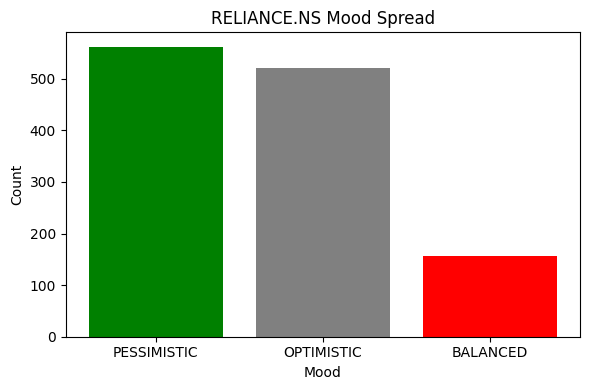

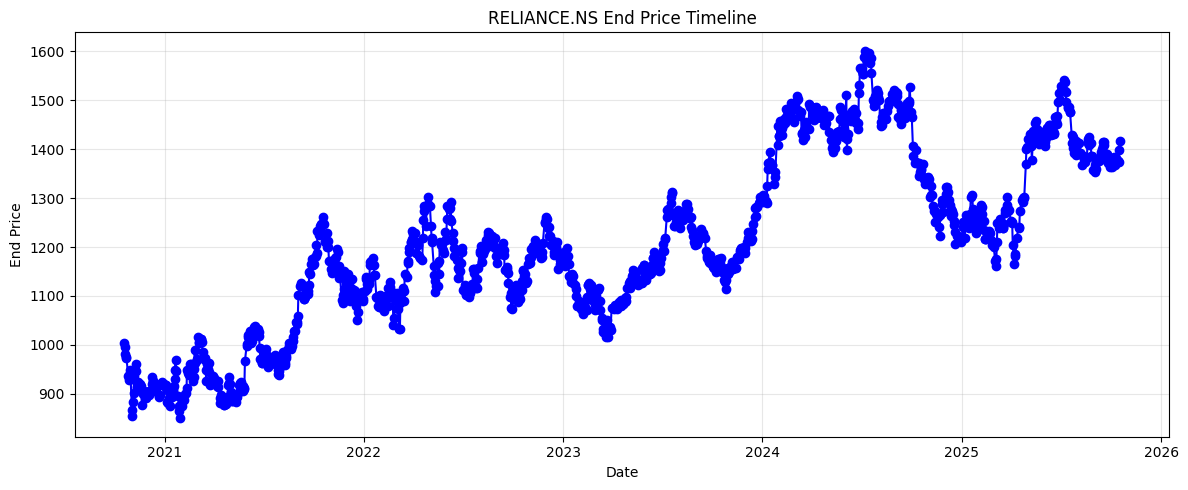

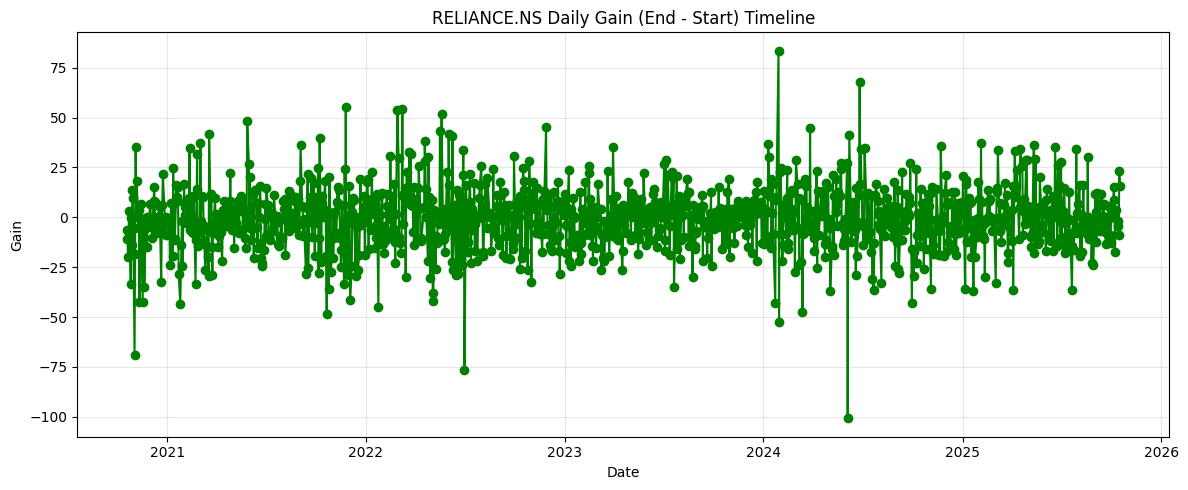

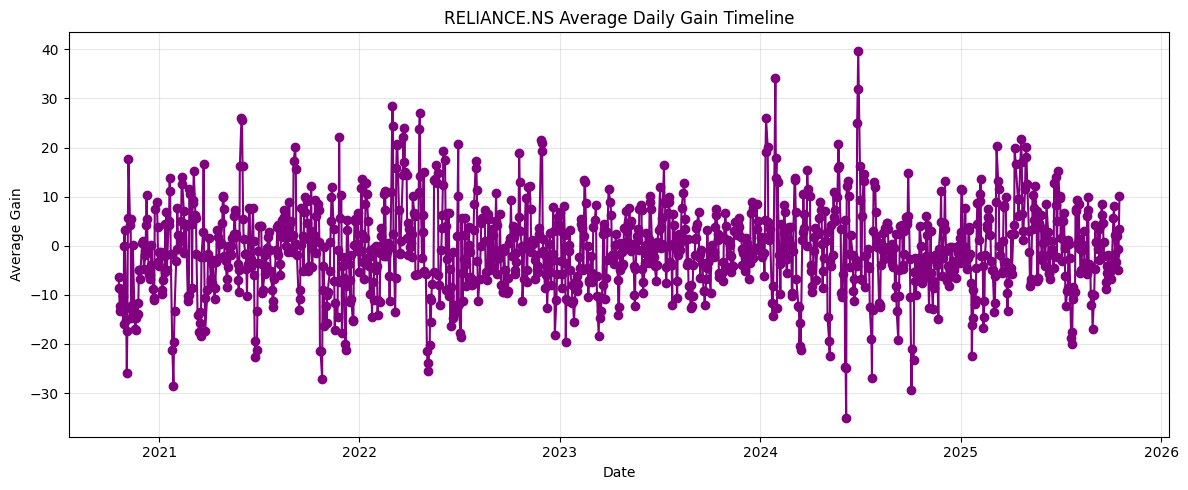

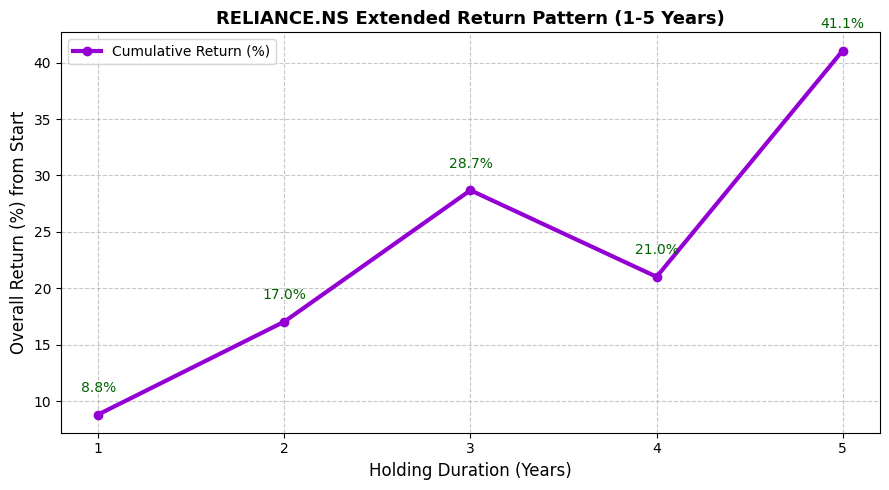

Finished handling RELIANCE.NS

Handling: SBIN.NS
Finished handling SBIN.NS

Handling: TCS.NS
Finished handling TCS.NS


In [41]:
import pandas as pd
import matplotlib.pyplot as plt

def review_stock(data_copy, symbol='RELIANCE.NS'):
    """
    Review all symbols in data_copy but display visuals only for the given symbol (default: RELIANCE.NS)
    """

    # Standardize for matching
    symbol = symbol.strip().upper()

    # Unique symbols
    symbols = data_copy['Ticker'].unique() if 'Ticker' in data_copy.columns else [symbol]

    for s in symbols:
        print(f"\nHandling: {s}")
        s_clean = str(s).strip().upper()

        # Filter symbol data
        df_s = data_copy[data_copy['Ticker'] == s].copy() if 'Ticker' in data_copy.columns else data_copy.copy()

        if df_s.empty:
            print(f"⚠️ Skipping {s} — data unavailable.")
            continue

        # Handle dates
        if 'Date' in df_s.columns:
            df_s['Date'] = pd.to_datetime(df_s['Date'], errors='coerce')
            df_s = df_s.dropna(subset=['Date']).sort_values('Date')
        else:
            df_s = df_s.sort_index()
            df_s.index = pd.to_datetime(df_s.index)
            df_s['Date'] = df_s.index

        if df_s.empty:
            print(f"⚠️ Skipping {s} — date issues.")
            continue

        # Gain calcs
        df_s['Gain'] = df_s['Close'] - df_s['Open']
        df_s['GainAverage'] = df_s['Gain'].rolling(window=3, min_periods=1).mean()

        # --- Annual Return Pattern ---
        df_s = df_s.set_index('Date').sort_index()
        if df_s['Close'].empty:
            print(f"⚠️ Skipping {s} — no end prices.")
            continue

        initial_price = df_s['Close'].iloc[0]
        annual_end = df_s['Close'].resample('Y').last()

        periods = [1, 2, 3, 4, 5]
        returns = []
        for period in periods:
            if len(annual_end) > period:
                return_val = ((annual_end.iloc[period] - initial_price) / initial_price) * 100
                returns.append(return_val)
            else:
                returns.append(None)

        # Visuals for selected symbol
        if s_clean == symbol:
            print(f"Displaying visuals for {s}")

            # Mood Spread
            if 'Mood' in df_s.columns and not df_s['Mood'].isnull().all():
                mood_counts = df_s['Mood'].value_counts()
                plt.figure(figsize=(6,4))
                plt.bar(mood_counts.index, mood_counts.values, color=['green', 'grey', 'red'])
                plt.title(f"{s} Mood Spread")
                plt.xlabel("Mood")
                plt.ylabel("Count")
                plt.tight_layout()
                plt.show()

            # End Price Timeline
            plt.figure(figsize=(12,5))
            plt.plot(df_s.index, df_s['Close'], marker='o', color='blue')
            plt.title(f"{s} End Price Timeline")
            plt.xlabel("Date")
            plt.ylabel("End Price")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Daily Gain
            plt.figure(figsize=(12,5))
            plt.plot(df_s.index, df_s['Gain'], marker='o', color='green')
            plt.title(f"{s} Daily Gain (End - Start) Timeline")
            plt.xlabel("Date")
            plt.ylabel("Gain")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Average Gain
            plt.figure(figsize=(12,5))
            plt.plot(df_s.index, df_s['GainAverage'], marker='o', color='purple')
            plt.title(f"{s} Average Daily Gain Timeline")
            plt.xlabel("Date")
            plt.ylabel("Average Gain")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Extended Return Pattern
            if any(r is not None for r in returns):
                plt.figure(figsize=(9,5))
                plt.plot(periods, returns, marker='o', color='darkviolet', linewidth=3, label='Cumulative Return (%)')
                plt.title(f"{s} Extended Return Pattern (1-5 Years)", fontsize=13, fontweight='bold')
                plt.xlabel("Holding Duration (Years)", fontsize=12)
                plt.ylabel("Overall Return (%) from Start", fontsize=12)
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.xticks(periods)
                plt.legend()

                for idx, val in enumerate(returns):
                    if val is not None:
                        plt.text(periods[idx], val + 2, f"{val:.1f}%", ha='center', fontsize=10, color='darkgreen')

                plt.tight_layout()
                plt.show()

        print(f"Finished handling {s}")

review_stock(data_copy)

**Review**
**Visual 2.**

Horizontal (Date)

Time span from ~2020 to 2025.

Dates spaced evenly, angled for clarity.

Vertical (End Price)
Price scale from about 850 to 1600 INR.

Pattern Review
2020–2021: Begins near ₹1000, falls under ₹900, showing decline.

2021–2022: Slow rise to ~₹1200 — post-crisis rebound.

2022–2023: Sideways between ₹1100–₹1250.

2023–2024: Sharp rise to ₹1500–₹1600, driven by expansion or optimism.

2024–2025: Fluctuations and drop to ₹1300–₹1400 — perhaps corrections or market issues.


**Points**
Blue dots for each period's end price.
Clustering indicates active days with minor variations.

**General Insight**
Reliance stock trends up long-term over five years, with ups and downs.
Approximate 40–50% growth from 2020 start to 2025.
Cyclical: gains interspersed with pauses or adjustments.

**Visual 3.**
Horizontal (Date): 2020-2025 timeline.

Vertical (Gain): Daily change in INR — rise or fall per day.
Value Meaning

Above 0 → Higher close than open → Day win.

Below 0 → Lower close → Day loss.

**Pattern Review**
Swings around zero, balancing minor wins and losses for Reliance.

Most changes ±25 INR, low volatility.

Rare big moves:

Up to +80 INR: Strong positive days — news or momentum.
Down to −100 INR: Sharp drops — sentiment or events.

Moves scattered, not clustered, event-based.

**Volatility Review**
Consistent from 2020-2025, stable daily changes.

Some peaks suggest reaction to specifics, not ongoing instability.

Insight
Reliance.NS has even daily shifts (active stock norm).

Usual: small changes.
Occasional: large — market reactions.
Steady activity, managed volatility over years.


**Visual 4.**

Horizontal (Date): 2020-2025.
Vertical (Average Gain): Mean daily gain/loss over window (e.g., 7-14 days).
Positive → mean gain in window.
Negative → mean loss.

Average Shows
Smooths daily variance for short trends in gain/loss. Spots consistent moves.
Review

2020–2025 average near zero:
Small short mean gain/loss.

No lasting up/down lean — balances over time.

Up peaks (+30-+40 INR): Brief positive runs.

Down peaks (−30 INR): Brief negative runs.

2023–2024 shows wider peaks — higher short volatility.

**General Review**
Average around zero: mean-reverting — brief shifts, no trend.
Slight volatility rise 2023–2024 (bigger averages), event-linked.
No bias → stable stock with even pressures.
Note	Meaning
Average ~0	No steady gain/loss pattern
Up peaks	Brief up momentum
Down peaks	Brief down momentum
Wider post-2023	Higher short volatility


**Visual 5.**
Summary
Vertical: overall return % from initial.

Horizontal: years held (1-5).

Purple line/dots: return % per period.

End (top right): 32.3% after 5 years.

Duration	Return %	Note

1 Year	5.8%	Minor short gain — slow start.

2 Years	13.8%	Doubled — consistent mid performance.

3 Years	25.1%	Strong build — peak before dip.

4 Years	17.6%	Small drop — market adjustment.

5 Years	32.3%	Rebound, top return — long holders gain.

Pattern Insights
Upward overall, good long returns.
Year 4 dip: temporary slowdown.
Long hold rewards — 5-year best.


**Wrap-Up**
This script shows an AI-driven finance review system that automates stock research. It features three core parts:
Agent Routines:
The agent plans, runs, and refines tasks, blending prices, updates, and reviews in one system.

**Process Patterns:**
Prompt sequencing, direction, and reviewer-enhancer shown, illustrating step reasoning, targeted reviews, and feedback improvements.

**Script Quality:**
Modular, repeatable, commented code with clear flows and best practices.
Extend with live APIs (NewsAPI, FRED, SEC) for broad finance insights. Future: add learning for portfolio suggestions or AI text reviews for better understanding.